<h1 style="text-align: center; font-family: 'Arial', sans-serif; color: #2c3e50;">
  <strong>Physics-Enhanced Machine Learning: An introduction to PINNs</strong>
</h1>

<hr style="border: 1px solid #2c3e50; width: 80%; margin: auto;">

<p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  This notebook provides a detailed walkthrough for solving a Sinusoidal Velocity ODE using both methods. It offers a clear comparison between the data-driven solver and the PINNs approach, covering model setup, training, and result analysis.

</p>

<p style="text-align: center; font-family: 'Arial', sans-serif; color: #34495e; font-size: 18px;">
  <strong>Authors notebook</strong><br>
  </p>
  PhD student Lucas Tesan
  </p>
  PhD student Mikel Martinez
</p>



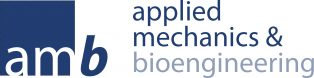

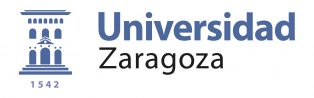

### Setting Python environment

**Preloaded libraries and functions.**

In [ ]:
%%capture
!pip install pytorch-lightning

In [ ]:
# import math libraries
import numpy as np
# import plotting libraries
import matplotlib.pyplot as plt
# import Deep Learning libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

*Real-time metrics plotter*

In [ ]:
from IPython.display import display, HTML, Javascript

class MetricsPlotter(pl.Callback):
    def __init__(self, ymax=1.):
        super().__init__()
        self.epoch = 0
        self.ymax = ymax
        self.metrics = {'train_loss': [np.inf], 'val_loss': [np.inf]}

    def set_template(self):
        css_style = f"""
          <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
          <style>
          .canvas-container {{
            display: flex;
            justify-content: center;
            width: 1000px;
          }}
          .chart-wrapper {{
            width: 800px;
            height: 500px;
          }}
          </style>

          <div class="canvas-container">
            <div class="chart-wrapper">
              <canvas id="chart0"></canvas>
            </div>
          </div>

          <script>
          const chartLabels = ['Train Loss', 'Validation Loss'];
          const chartOptions = {{'ticksStep': 1, 'yMax': {self.ymax}}};

          const ctx = document.getElementById('chart0').getContext('2d');
          window.chart = new Chart(ctx, {{
              type: 'line',
              data: {{
                labels: Array.from({{length: {self.max_epochs}/100}}, (_, i) => (i + 1)*100),
                datasets: [{{
                  label: chartLabels[0],
                  data: [],
                  borderColor: 'blue',
                  backgroundColor: 'rgba(0, 0, 255, 0.1)',
                  borderWidth: 3,
                  pointStyle: false,
                }}, {{
                  label: chartLabels[1],
                  data: [],
                  borderColor: 'red',
                  backgroundColor: 'rgba(255, 0, 0, 0.1)',
                  borderWidth: 3,
                  pointStyle: false,
                }}]
              }},
              options: {{
                responsive: true,
                maintainAspectRatio: false,
                animation: false,
                scales: {{
                  y: {{
                    type: 'logarithmic',  // Set y-axis to logarithmic scale
                    min: 0.000001,  // Set a sensible minimum for log scale
                    max: chartOptions['yMax'],
                    ticks: {{
                      stepSize: chartOptions['ticksStep'],
                      callback: function(value, index, values) {{
                        if (value === 0.000001) return '1e-6';
                        return value;
                      }}
                    }},
                    grid: {{
                      color: '#aaaaaa',
                      lineWidth: 1,
                      drawBorder: true,
                      drawOnChartArea: true
                    }}
                  }},
                  x: {{
                    min: 0.0,
                    max : {self.max_epochs},
                    grid: {{
                      color: '#eeeeee',
                      lineWidth: 1,
                      drawBorder: true,
                      drawOnChartArea: true
                    }}
                  }}
                }}
              }}
            }});

          // update chart
          function uc(loss, val_loss) {{
            window.chart.data.datasets[0].data.push(loss);
            window.chart.data.datasets[1].data.push(val_loss);
            window.chart.update();
          }}
          </script>
          """
        display(HTML(css_style))

    def on_validation_epoch_end(self, trainer, pl_module):

        self.max_epochs = trainer.max_epochs
        # Assuming you log training loss on each batch
        train_loss = trainer.logged_metrics.get('train_loss', 0)
        if isinstance(train_loss, torch.Tensor):
            train_loss = train_loss.cpu().numpy().item()
        self.metrics['train_loss'].append(train_loss)

        val_loss = trainer.logged_metrics.get('val_loss', 0)
        if isinstance(val_loss, torch.Tensor):
            val_loss = val_loss.cpu().numpy().item()
        self.metrics['val_loss'].append(val_loss)

        self.plot_metrics(trainer)

    def plot_metrics(self, trainer):
        if self.epoch == 0:
            self.set_template()

        # Update the chart with new loss and val_loss values
        display(Javascript(f'''
        uc({self.metrics['train_loss'][-1]}, {self.metrics['val_loss'][-1]});
        '''))
        self.epoch = trainer.current_epoch


import matplotlib.pyplot as plt
from PIL import Image
import io
from IPython.display import Image as IPImage, display

def make_gif(stored_predictions, title=''):

    # List to hold images for the GIF
    frames = []

    # Duration for each frame (in milliseconds)
    normal_duration = 200
    last_frame_duration = 5000  # 5 seconds for the last frame

    for epoch, prediction_model in stored_predictions.items():
        # Create a figure and plot
        fig, ax = plt.subplots(figsize=(10, 6))
        if 'pinn' in title:
            plt.scatter(train_t, len(train_t)*[0.8], color='red', label='Training time points', alpha=0.5)
            plt.scatter(valid_t, len(valid_t)*[0.8], color='orange', label='Validation time points', alpha=0.5)
            plt.scatter(0, 1, color='red', label='Initial Condition')
        else:
            ax.scatter(train_t, train_u, color='red', label='Training Data Points')
            ax.scatter(valid_t, valid_u, color='orange', label='Validation Data Points')
        ax.plot(time, analytical_solution, label='Analytical Solution', color='blue', alpha=0.5)
        ax.plot(time, prediction_model, color='black', label='Learned Model', alpha=0.75)

        error = np.mean(np.abs(analytical_solution - prediction_model))

        ax.fill_between(time, analytical_solution, prediction_model, color='red', alpha=0.1,
                        label=f'Error mae: {round(error, 4)}')

        ax.set_title(f'Analytical Solution vs Learned Model - Epoch {epoch}')
        ax.set_xlabel('t')
        ax.set_ylabel('u(t)')
        ax.set_ylim([0.7, 1.3])
        ax.legend()
        ax.grid(True)

        # Save the figure to an in-memory buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)

        # Seek to the beginning of the buffer
        buf.seek(0)

        # Read the image from the buffer and append it to the frames list
        img = Image.open(buf)
        frames.append(img)

    # Create the GIF from the frames in memory
    buf_gif = io.BytesIO()
    frames[0].save(buf_gif, format='GIF', save_all=True, append_images=frames[1:],
                   duration=[normal_duration] * (len(frames) - 1) + [last_frame_duration],
                   loop=0)

    # Seek to the beginning of the buffer
    buf_gif.seek(0)

    # Display the GIF in the notebook
    display(IPImage(buf_gif.read()))

    frames[0].save(f'model_evolution_prediction_{title}.gif', format='GIF', save_all=True, append_images=frames[1:],
                   duration=[normal_duration] * (len(frames) - 1) + [last_frame_duration],
                   loop=0)


# **Simple ODE: sinusoidal velocity**


- Let's look at the ODE:

<br>
$$\frac{du}{dt} = \cos2\pi t$$

- Initial condition:

<br>
$$u(0) = 1$$

- The exact solution:

<br>
$$u(t) = \frac{1}{2\pi}\sin2\pi t + 1$$


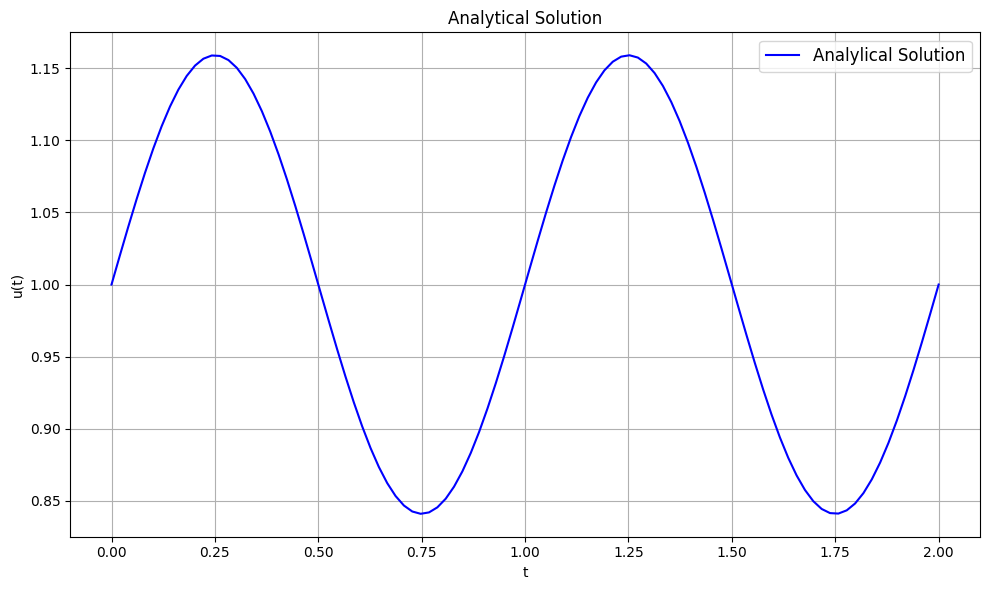

### Analytical solution

In [ ]:
# Set a control seed for reproducibility
np.random.seed(52)  # You can change 52 to any integer value for a different sequence

# Exact analitical solution function
def generate_solution_data_points(t):
    return np.sin(2 * np.pi * t) / (2 * np.pi) + 1

# Evaluate the analytical solution on a fine grid of t values
T = 2
time = np.linspace(0, T, 100)
analytical_solution = generate_solution_data_points(time)


### Data $D$
In this case, we know the distribution because we have the analytical solution. However, in most real-world scenarios, we do not have access to the full distribution and only have a few samples from it. The analytical solution is given by
$$u(t) = \frac{1}{2\pi}\sin2\pi t + 1$$

To emulate this real-world scenario, we'll randomly sample 30 data points from this distribution.

In [ ]:
# Simulate real world scenario by random sampling data
num_sampled_t = 30
sampled_t = (np.random.rand(num_sampled_t) * T).reshape(-1, 1)
sampled_u = generate_solution_data_points(sampled_t)

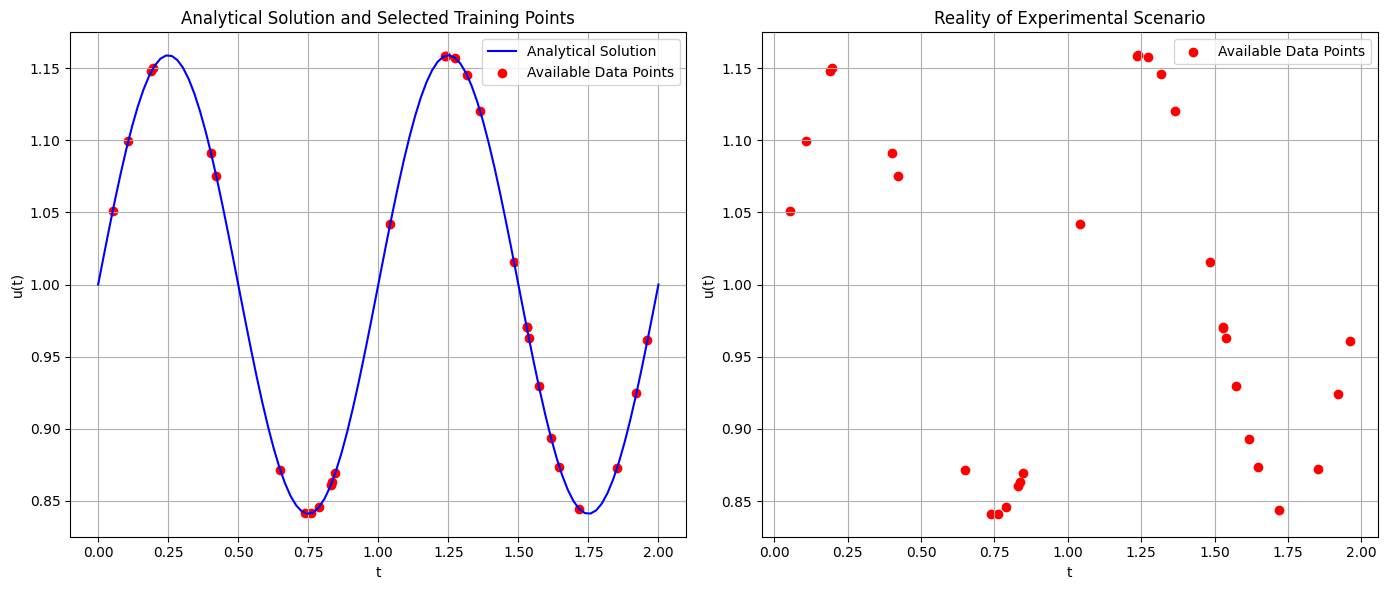

In [ ]:
# Create a figure and two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Plot the analytical solution and sampled data points
ax1.plot(time, analytical_solution, label='Analytical Solution', color='blue')
ax1.scatter(sampled_t, sampled_u, color='red', label='Available Data Points')
ax1.set_title('Analytical Solution and Selected Training Points')
ax1.set_xlabel('t')
ax1.set_ylabel('u(t)')
ax1.legend()
ax1.grid(True)

# Second subplot: Plot only the sampled data points
ax2.scatter(sampled_t, sampled_u, color='red', label='Available Data Points')
ax2.set_title('Reality of Experimental Scenario')
ax2.set_xlabel('t')
ax2.set_ylabel('u(t)')
ax2.legend()
ax2.grid(True)

# Show the combined plots
plt.tight_layout()  # Adjust the layout so that it doesn't overlap
plt.show()

# Supervised Learning: Learning from data


## Modeling from **available data** when **unknown ODE**

Deep learning is a modeling technique that involves tuning a **model's parameters θ** to fit the data during the training process, driven by the **data $D_{train}$**. This tuning is achieved by minimizing a **loss function**, denoted as **$L_{total}$,** through the backpropagation algorithm, which is a first-order optimization method.

Deep learning can essentially be viewed as an **optimization problem**, where the objective is to minimize a specified loss function for the given data and model. By doing so, the model learns from the data to model the solution to the differential equation $u(t)$.

$$\underset{\theta}{\operatorname{argmin}} \, f(D_{train},\theta, L_{total})
$$

This approach follows the paradigm of **supervised learning**, where samples of the solution to the ODE are used to model our ODE. Because it's supervised the **$D_{train}$** are input-output pairs [$t$, $u(t)$] of time and its analytical solution, where $u(t)$ acts as the label.

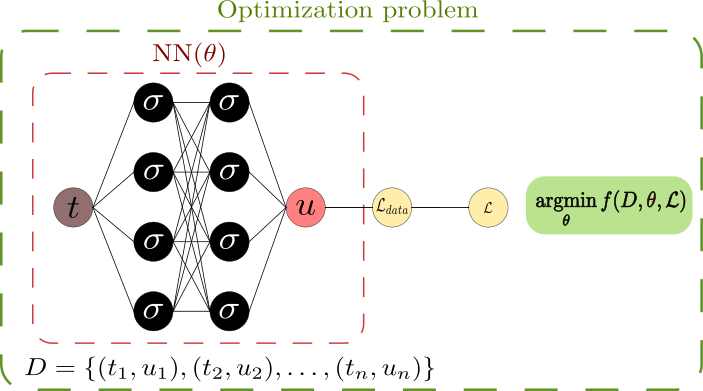


### Loss function $L$
When no prior knowledge about the problem is available, and only data is provided, the loss function is often chosen as a generic convex function, such as Mean Squared Error (MSE). This is because convex functions, like MSE, have desirable properties that simplify optimization, making them a common choice in such scenarios.

- Data-driven prediction loss:
<br>
$$L_{\text{data}} = \frac{1}{n}\sum_{i=1}^{n} \left(\text{NN}(i) - u_i\right)^2$$ , where $u_i$ is the data $i$-th solution of the ODE and $\text{NN}(t_i)$ is the $i$-th prediciton of the Neural Network.

- Total loss:
<br>
$$L_{\text{Total}} = L_{\text{data}}$$

In [ ]:
def loss_data(t, y, solver):
  y_pred = solver.forward(t)
  loss_data = torch.mean((y_pred - y)**2)
  return {'loss': loss_data}

### Models $θ$


*   **Model low paramters**: Multi-Perceptron-Layer model a baseline with **1** hidden layer of **32** units and ***tahn*** activation function

In [ ]:
# Instantiate the model
base_model = torch.nn.Sequential(
                torch.nn.Linear(1, 32),
                torch.nn.Tanh(),
                torch.nn.Linear(32, 32),
                torch.nn.Tanh(),
                torch.nn.Linear(32, 1)
                                )
print(base_model)

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
class Solver(pl.LightningModule):
    """ Authors: PhD Mikel M Iparraguirre | PhD Lucas Tesan
                 mikel.martinez@unizar.es | ltesan@unizar.es
        University of Zaragoza, Applied Mechanics Department (AMB)
    """
    def __init__(self, base_model, criterion=loss_data, lr=5e-4, optimizer=torch.optim.Adam, T=2):
        super(Solver, self).__init__()
        self.model = base_model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr = lr

        self.T = T
        self.stored_predictions = dict()

    def forward(self, x):
        x = self.model(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        losses = self.criterion(x, y, self)
        for name_loss, value_loss in losses.items():
            self.log(f'train_{name_loss}', value_loss.cpu().detach().item(), on_epoch=True, on_step=False)

        return losses['loss']

    def validation_step(self, batch, batch_idx):
        x, y = batch
        losses = self.criterion(x, y, self)
        for name_loss, value_loss in losses.items():
            self.log(f'val_{name_loss}', value_loss.cpu().detach().item(), on_epoch=True, on_step=False)

        self.store_prediction()

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.lr)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs, eta_min=1e-5),
            'monitor': 'train_loss'}

        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}

    def store_prediction(self):
        time = np.linspace(0, T, 100)
        time_t_tensor = torch.tensor(time, dtype=torch.float32).reshape(-1, 1).to(self.device)
        predicted_solution = self.forward(time_t_tensor)
        self.stored_predictions[f'{self.current_epoch}'] = predicted_solution.cpu().detach().numpy().reshape(-1)



### Data Spliting $D_{train}$ and $D_{valid}$ to avoid **overfitting**

In real-world scenarios data is limited. Deep learning techniques are powerful but the tend to **overfit** the solutions to our **training data**, meaning that the resulting model won't generalize well, hence we haven't solve the problem correclty.

For better practice we will randomly split our 40 available data points into 30 for training $D_{train}$ and 10 for validation $D_{valid}$.

Here we will also convert the data into tensors for traning preparation.

In [ ]:
from sklearn.model_selection import train_test_split
# split data into train and validatio
train_t, valid_t, train_u, valid_u = train_test_split(sampled_t, sampled_u, test_size=0.20, random_state=52)

# Convert data to PyTorch tensors
train_t = torch.tensor(train_t, dtype=torch.float32)
train_u = torch.tensor(train_u, dtype=torch.float32)
valid_t = torch.tensor(valid_t, dtype=torch.float32)
valid_u = torch.tensor(valid_u, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_t, train_u)
valid_dataset = TensorDataset(valid_t, valid_u)

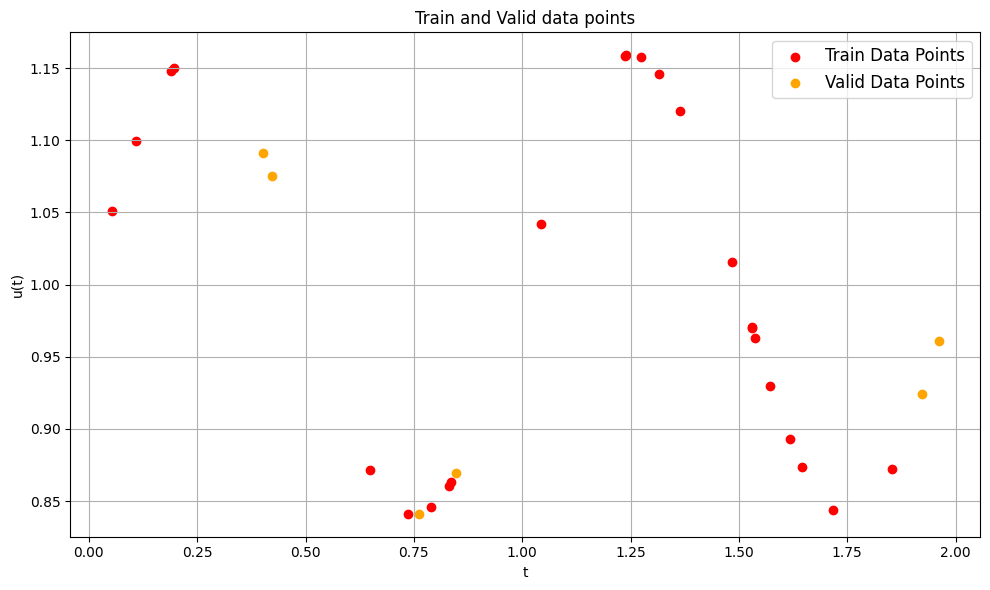

In [ ]:
# Plot the exact solution and training points
plt.figure(figsize=(10, 6))

plt.scatter(train_t, train_u, color='red', label='Train Data Points')
plt.scatter(valid_t, valid_u, color='orange', label='Valid Data Points')

plt.title('Train and Valid data points')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Training process

Beyond the parameters **θ** of our model, there is another crucial set of parameters that must be configured during the training of deep neural networks. These are known as *hyperparameters*. Unlike model parameters, which are learned during training, hyperparameters are set before the training process begins and play a **key role** in achieving high-quality solutions.

### Hyperparameters in the Training Process:

*   **Epochs**: How much training. Number of times the entire training dataset is passed through the model during training
*   **Batch size**: Number of samples used to compute the error at each back-propagation
*   **Learning Rate**: Determines the size of the steps the optimizer takes when updating the model's parameters during backpropagation.
*   **Optimizer**: The algorithm that determines the gradient from the loss function, afecting in how the model's parameters are updated. It may include techniques like momentum, inertia, and adaptive learning rates.

### Regularization Techniques:
*   **Early Stopping**: A technique that halts the training process when the model's performance on a validation set begins to deteriorate, indicating overfitting.

In [ ]:
# Hyper-paramters
epochs = 10000
batch_size = 32
lr = 1e-3
optm = torch.optim.Adam
# Regularization techniques
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Model setup
model = Solver(base_model, criterion=loss_data, lr=lr, optimizer=optm)
# Trainer setup
trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                      max_epochs=epochs,
                      callbacks=[MetricsPlotter(), early_stopping], check_val_every_n_epoch=100)

# Training the model
trainer.fit(model, train_loader, valid_loader)
# Save the model
torch.save(model.state_dict(), './model_data_driven.pth')

In [ ]:
def inference_model_and_performance(model, time, analytical_solution):
    # Generate high resolution learned solutions
    test_t_tensor = torch.tensor(time, dtype=torch.float32).reshape(-1, 1)
    # set model to evaluate
    model.eval()
    predicted_solution = model(test_t_tensor).ravel().detach().numpy()
    # compute MAE error
    error = np.abs(analytical_solution - predicted_solution)
    mean_error = np.mean(error)
    return predicted_solution, mean_error

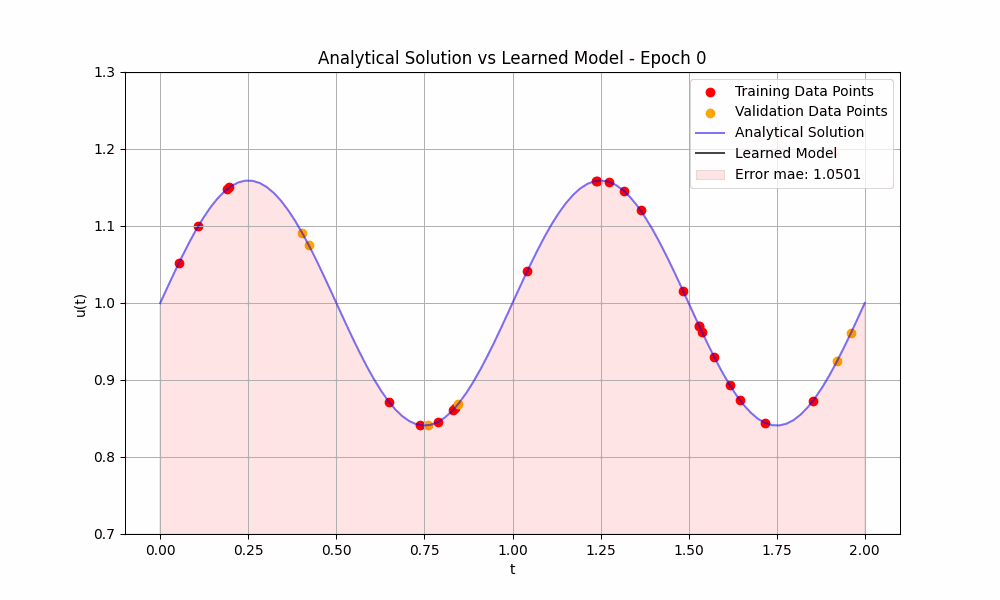

In [ ]:
make_gif(model.stored_predictions, title='data')

# Self-Supervised Learning: Deep Learning as a ODE Solver

## Modeling from **known ODE** when **unavailable data**

Deep learning is a modeling technique that involves tuning a **model's parameters θ** to fit the data during the training process, driven by the **data $D_{train}$**. This tuning is achieved by minimizing a **loss function**, denoted as **$L_{total}$,** through the backpropagation algorithm, which is a first-order optimization method.

Deep learning can essentially be viewed as an **optimization problem**, where the objective is to minimize a specified loss function for the given data and model. By doing so, the model learns from the data and becomes capable of making accurate predictions or decisions

$$\underset{\theta}{\operatorname{argmin}} \, f(D_{train},\theta, L_{total})
$$
####  Key points ODE-supervised learning

*   Design **$L_{total}$** based on ODE residuals **$L_{r}$**
*   No analytical solution's data or experimental observations
*   Unlimited $D$, because only colocation points $t$ values are needed $D_{time}$

$$\underset{\theta}{\operatorname{argmin}} \, f(D_{time},\theta, L_{r})
$$

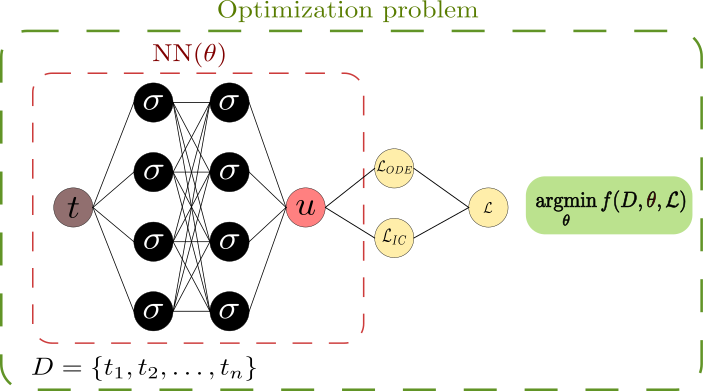

### Data $D$

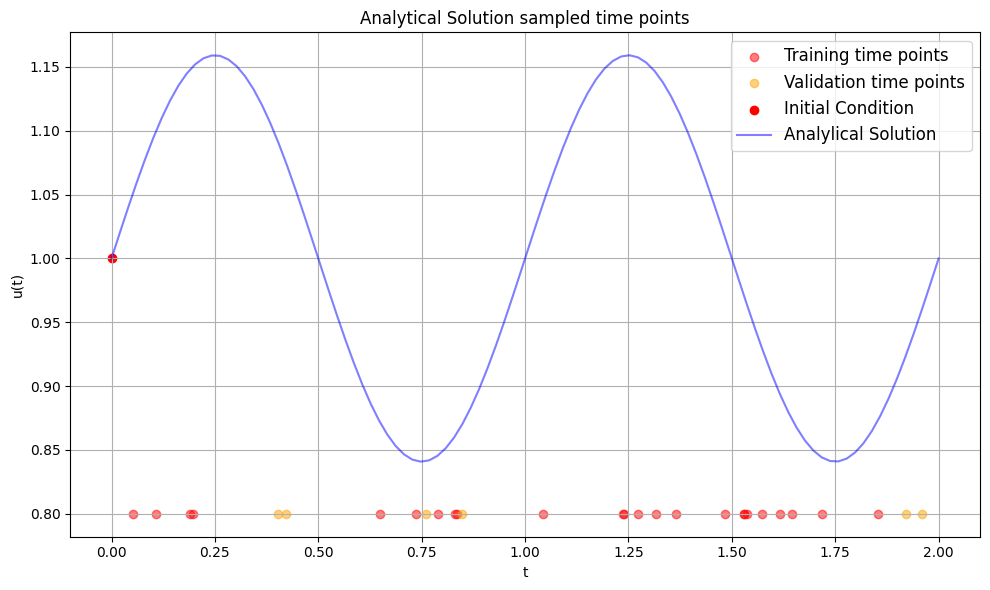

In [ ]:
# Plot the exact solution and training points
plt.figure(figsize=(10, 6))
plt.scatter(train_t, len(train_t)*[0.8], color='red', label='Training time points', alpha=0.5)
plt.scatter(valid_t, len(valid_t)*[0.8], color='orange', label='Validation time points', alpha=0.5)
plt.scatter(0, 1, color='red', label='Initial Condition')

plt.plot(time, analytical_solution, label='Analylical Solution', color='blue', alpha=0.5)

plt.title('Analytical Solution sampled time points')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Loss based on residuals ODE

Knowing that any proposed solution $u(t)$ that is a solution to the ODE, our loss function is no longer just a generic Mean Squared Error (MSE). Now, the residuals from the Ordinary Differential Equation (ODE) and the Initial Condition (IC), respectively will construct our loss.

- ODE loss:
<br>
$$L_{\text{ODE}} = \frac{1}{n}\sum_{i=1}^{n} \left(\frac{d \text{NN}(t_i)}{dt}- \cos2\pi t_i\right)^2$$

- Initial condition loss:
<br>
$$L_{IC} = \frac{1}{n}\sum_{i=1}^{n} \left({\text{NN}(0)}- 1\right)^2$$

- Total loss:
<br>
$$L_{\text{Total}} = L_{\text{ODE}} + L_{\text{IC}}$$

In [ ]:
def loss_ode(t, solver):
    # Ensure t requires gradient computation
    t.requires_grad_(True)

    # Enable gradient computation manually
    with torch.set_grad_enabled(True):
        # Compute the neural network output u(t)
        u = solver.forward(t)
        # Compute the derivative of u with respect to t
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # Compute the ODE loss: difference between u_t and the target function's derivative
        ode_loss = u_t - torch.cos(2 * torch.pi * t)
        ode_sm_loss = torch.mean(ode_loss ** 2)

    return ode_sm_loss

# Define the Initial Condition (IC) loss function
def loss_ic(solver):
    # Define initial condition (t=0) and the target value at t=0
    t_0 = torch.zeros((1, 1), dtype=torch.float32).to(solver.device)
    one = torch.ones((1, 1), dtype=torch.float32).to(solver.device)
    ic_loss = solver.forward(t_0) - one
    ic_sm_loss = torch.mean(ic_loss ** 2)

    return ic_sm_loss

In [ ]:
# Define the total loss function
def loss_pinn(t, y, solver):
    # Compute the ODE loss: difference between u_t and the target function's derivative
    ode_loss = loss_ode(t, solver)
    ic_loss = loss_ic(solver)

    total_loss = 3*ode_loss + ic_loss

    return {'loss': total_loss, 'ode_loss': ode_loss, 'ic_loss': ic_loss}

### Models $θ$


*   **Model low parameters**: Multi-Perceptron-Layer model a baseline with **1** hidden layer of **32** units and ***tahn*** activation function
* **PINN** Solver

In [ ]:
# Instantiate the model
base_model = torch.nn.Sequential(
                torch.nn.Linear(1, 32),
                torch.nn.Tanh(),
                torch.nn.Linear(32, 32),
                torch.nn.Tanh(),
                torch.nn.Linear(32, 1))

## Training process

Beyond the parameters **θ** of our model, there is another crucial set of parameters that must be configured during the training of deep neural networks. These are known as *hyperparameters*. Unlike model parameters, which are learned during training, hyperparameters are set before the training process begins and play a **key role** in achieving high-quality solutions.

### Hyperparameters in the Training Process:

*   **Epochs**
*   **Batch size**
*   **Learning Rate**
*   **Optimizer**

### Regularization Techniques:
*   **Early Stopping**

In [ ]:
# Hyper-paramters
epochs = 5000
batch_size = 32
lr = 1e-3
optm = torch.optim.Adam
# Regularization techniques
early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', patience=500, mode='min')

In [ ]:
# Model setup
model = Solver(base_model, criterion=loss_pinn, lr=lr, optimizer=optm)
# Trainer setup
trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                      max_epochs=epochs,
                      callbacks=[MetricsPlotter(ymax=10), early_stopping],
                     check_val_every_n_epoch=100, log_every_n_steps=1)

# Training the model
trainer.fit(model, train_loader, valid_loader)
# Save the model
torch.save(model.state_dict(), './model_pinn.pth')

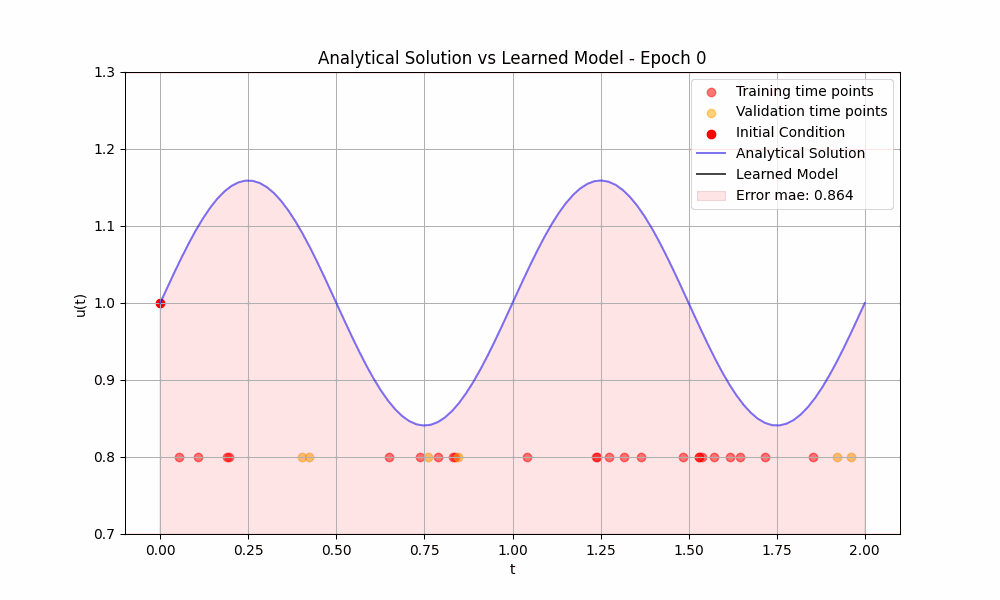

In [ ]:
make_gif(model.stored_predictions, title='pinn')

### Generalization out of training range

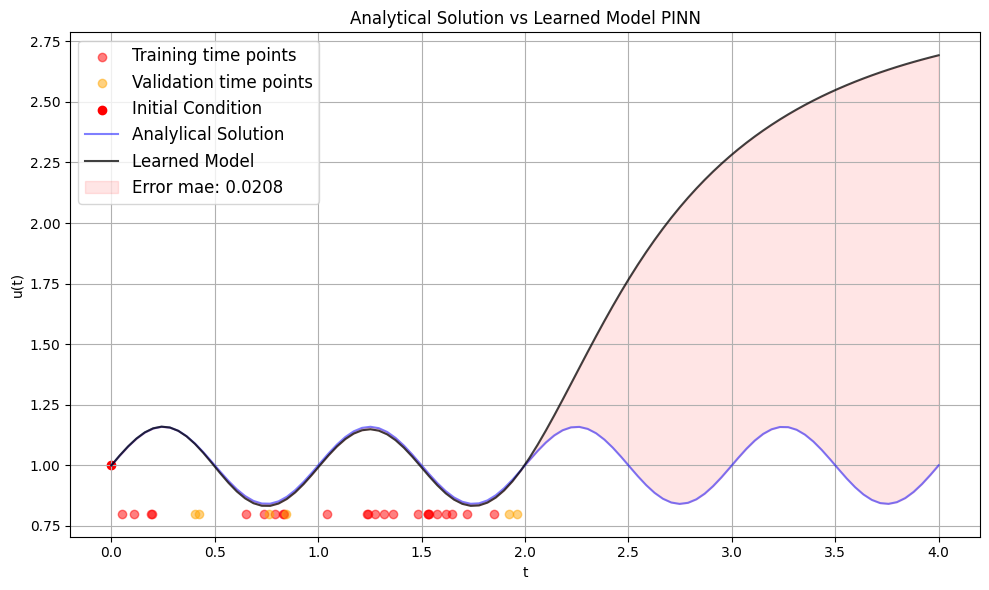

In [ ]:
# Evaluate the analytical solution on a fine grid of t values
T = 4
time = np.linspace(0, T, 100)
analytical_solution = generate_solution_data_points(time)
predicted_solution, mae_error = inference_model_and_performance(model, time, analytical_solution)

# Plot the exact solution and training points
plt.figure(figsize=(10, 6))
plt.scatter(train_t, len(train_t)*[0.8], color='red', label='Training time points', alpha=0.5)
plt.scatter(valid_t, len(valid_t)*[0.8], color='orange', label='Validation time points', alpha=0.5)
plt.scatter(0, 1, color='red', label='Initial Condition')
plt.plot(time, analytical_solution, label='Analylical Solution', color='blue', alpha=0.5)
plt.plot(time, predicted_solution, color='black', label = 'Learned Model', alpha=0.75)

plt.fill_between(time, analytical_solution, predicted_solution, color='red', alpha=0.1, label=f'Error mae: {round(mae_error, 4)}')

plt.title('Analytical Solution vs Learned Model PINN')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.legend()
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# **Hope you liked this introduction to the PINNs!**

Contact the creators for any inquiries:


*   mikel.martinez@unizar.es --> [Web](https://amb.unizar.es/people/mikel-martinez/)
*   ltesan@unizar.es --> [Web](https://amb.unizar.es/people/lucas-tesan/)



## **GPL License**


Copyright (c) 2024, AMB-PINNs PhD Mikel M. Iparraguirre & PhD Lucas Tesan

AMB-PINNs is licensed under the GNU General Public License version 3 (GPLv3) or later.

AMB-PINNs is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

AMB-PINNs is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with AMB-PINNs. If not, see <http://www.gnu.org/licenses/>.
